In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import cv2
import PIL
import shutil

## Loading the data

In [2]:
data_dir='../input/gan-getting-started'
class GANdataGenerator(Dataset):
    def __init__(self, data_dir ,  data_files , image_size ):
        super(GANdataGenerator , self).__init__()
        self.data_dir = data_dir
        self.data = data_files
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(image_size),
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomCrop((256, 256)),
            transforms.CenterCrop(image_size),
            transforms.ToTensor()
        ])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        data_file = self.data[index]
        data_file = os.path.join(self.data_dir , data_file)
        img_bgr = cv2.imread(data_file)
        img_rgb = cv2.cvtColor(img_bgr , cv2.COLOR_BGR2RGB)
        img_tensor = self.transform(img_rgb)
        
        return img_tensor

In [3]:
monet_jpg = os.listdir('../input/gan-getting-started/monet_jpg')
photo_jpg = os.listdir('../input/gan-getting-started/photo_jpg')

In [4]:
#load the Dataloader for X and Y image sets
X_type='photo_jpg'
Y_type='monet_jpg'
X_set = GANdataGenerator(data_dir='../input/gan-getting-started/photo_jpg' , data_files=photo_jpg , image_size=256 )
Y_set = GANdataGenerator(data_dir='../input/gan-getting-started/monet_jpg' , data_files=monet_jpg , image_size=256 )

X_dataloader = DataLoader(X_set , batch_size=4 , shuffle=True , num_workers=0)
Y_dataloader = DataLoader(Y_set , batch_size=4 , shuffle=True , num_workers=0)

In [5]:
x_data = next(iter(X_dataloader))
y_data = next(iter(Y_dataloader))

# Visualize the data

X data visualization


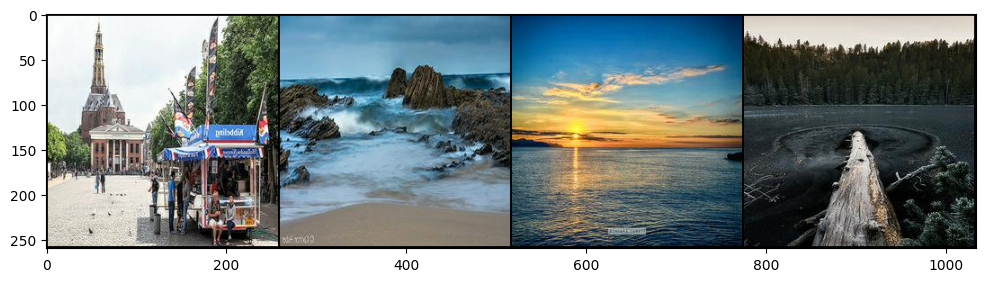

In [6]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1 ,2, 0)))
print("X data visualization")
fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(x_data))

Y data visualization


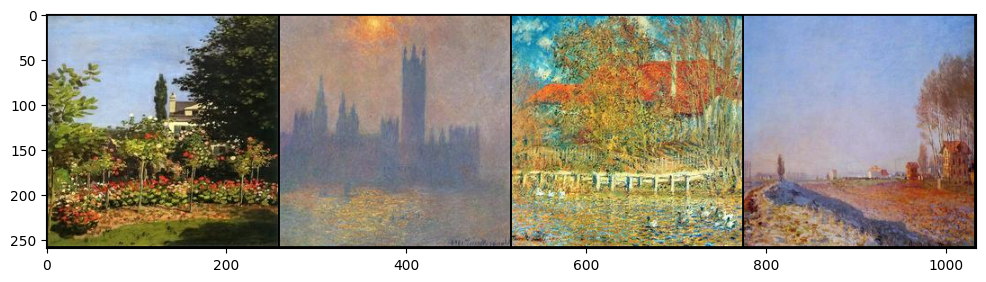

In [7]:
print("Y data visualization")
fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(y_data))

In [8]:
def viz_sample(samples_x , samples_y):
    #get random sample from the x and y
    #plot the sample
    plt.title("Real sample")
    plt.imshow(samples_x)
    plt.show()
    plt.title("Fake sample")
    plt.imshow(samples_y)
    plt.show()

In [9]:
def to_data(x):
    """Converts variable to numpy."""
    if torch.cuda.is_available():
        x = x.cpu()
    x = x.squeeze(0)
    x = x.data.numpy()
    x = np.transpose(x,(1,2,0))
    x = ((x +1)*255 / (2)).astype(np.uint8) # rescale to 0-255
    return x

## Preprocessing

Rescaling traing images from 0/1 to -1/1

In [10]:
img = x_data[0]

print("Min : ",img.min())
print("Max : ",img.max())

def rescale(x , feature_range=(-1,1)):
    min , max = feature_range
    x = x*(max - min) +min
    
    return x

Min :  tensor(0.)
Max :  tensor(1.)


In [11]:
# scaled range
scaled_img = rescale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-1.)
Scaled max:  tensor(1.)


# Building CycleGan Architecture

## Discriminator

In [12]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=1, bias=True, padding_mode="reflect"),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
        
    def forward(self, x):
        return self.conv(x)
        

In [13]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.disc = nn.Sequential(
            # 256/256/3 -> 128/128/64
            nn.Conv2d(in_channels, features[0], kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
            # 128/128/64 -> 64/64/128
            Block(features[0], features[1], stride=2),
            # 64/64/128 -> 32/32/256
            Block(features[1], features[2], stride=2),
            # 32/32/256 -> 16/16/512
            Block(features[2], features[3], stride=1),
            # 16/16/512 -> 30/30/1
            nn.Conv2d(features[3], 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"),
        )
        
    def forward(self, x):
        return torch.sigmoid(self.disc(x))

In [14]:
x = torch.randn((5, 3, 256, 256))
model = Discriminator(in_channels=3)
preds = model(x)
print(preds.shape)

torch.Size([5, 1, 30, 30])


## Generator

In [15]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs) if down else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity(),
        )
    
    def forward(self, x):
        return self.conv(x)

In [16]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1),
        )
        
    def forward(self, x):
        return x + self.block(x)

In [17]:
class Generator(nn.Module):
    def __init__(self, img_channels, num_features=64, num_residuals=9):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.ReLU(inplace=True),
            ConvBlock(num_features, num_features*2, kernel_size=3, stride=2, padding=1),
            ConvBlock(num_features*2, num_features*4, kernel_size=3, stride=2, padding=1),
        )
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(num_features*4) for _ in range(num_residuals)]
        )
        self.decoder = nn.Sequential(
            ConvBlock(num_features*4, num_features*2, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            ConvBlock(num_features*2, num_features, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Conv2d(num_features, img_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.residual_blocks(x)
        x = self.decoder(x)
        return torch.tanh(x)

In [18]:
img_channels = 3  
img_size = 256
x = torch.randn((2, img_channels, img_size, img_size))
gen = Generator(img_channels)
gen(x).shape

torch.Size([2, 3, 256, 256])

# Training

In [19]:
def train(G_X2Y, G_Y2X, D_X, D_Y, X_dataloader, Y_dataloader, opt_G, opt_D, L1, mse, G_scaler, D_scaler):
    #loop = tqdm(loader, leave=True)
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    
    print_every = 50
    n_epochs = 5000
    LAMBDA_IDENTITY = 0.1
    LAMBDA_CYCLE = 10
    
    test_iter_X = iter(X_dataloader)
    test_iter_Y = iter(Y_dataloader)
    
    # Get some fixed data from domains X and Y for sampling
    fixed_X = next(test_iter_X)[0]
    fixed_Y = next(test_iter_Y)[0]
    fixed_X = rescale(fixed_X) 
    fixed_Y = rescale(fixed_Y)
    
    # batches per epoch
    iter_X = iter(X_dataloader)
    iter_Y = iter(Y_dataloader)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):
        # Reset iterator for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(X_dataloader)
            iter_Y = iter(Y_dataloader)
            
        img_X = next(iter_X)
        img_X = rescale(img_X)
        
        img_Y = next(iter_Y)
        img_Y = rescale(img_Y)

        img_X = img_X.to(device)
        img_Y = img_Y.to(device)
        
        # Train Discriminators
        with torch.cuda.amp.autocast():
            # 1. Discriminator loss on real images X
            D_X_real = D_X(img_X)
            D_X_real_loss = mse(D_X_real, torch.ones_like(D_X_real))

            # 2. Generate fake images
            fake_x = G_Y2X(img_Y)

            # 3. Discriminator loss on fake images X
            D_X_fake = D_X(fake_x.detach())
            D_X_fake_loss = mse(D_X_fake, torch.ones_like(D_X_fake))

            # 4. Total loss for discriminator X
            D_X_loss = D_X_real_loss + D_X_fake_loss

            # 5. Same thing for discriminator Y
            D_Y_real = D_Y(img_Y)
            D_Y_real_loss = mse(D_Y_real, torch.ones_like(D_Y_real))

            fake_y = G_X2Y(img_X)

            D_Y_fake = D_Y(fake_y.detach())
            D_Y_fake_loss = mse(D_Y_fake, torch.ones_like(D_Y_fake))

            D_Y_loss = D_Y_real_loss + D_Y_fake_loss

            # 6. Total loss for discriminators X and Y
            D_loss = (D_X_loss + D_Y_loss) / 2
        
        # 7. Perform backdrop
        opt_D.zero_grad()
        D_scaler.scale(D_loss).backward()
        D_scaler.step(opt_D)
        D_scaler.update()
    
        
        # Train Generators
        with torch.cuda.amp.autocast():
            # 1. Generator loss based on domain X
            D_X_fake = D_X(fake_x)
            loss_G_X = mse(D_X_fake, torch.ones_like(D_X_fake))

            # 2. Create a reconstructed y
            cycle_y = G_X2Y(fake_x)

            # 3. Cycle loss
            cycle_Y_loss = L1(img_Y, cycle_y)

            # 4. Same thing for cycle_X
            D_Y_fake = D_Y(fake_y)
            loss_G_Y = mse(D_Y_fake, torch.ones_like(D_Y_fake))

            cycle_x = G_Y2X(fake_y)

            cycle_X_loss = L1(img_X, cycle_x)

            # 5. Identity loss
            identity_x = G_Y2X(img_X)
            identity_y = G_X2Y(img_Y)

            identity_X_loss = L1(img_X, identity_x)
            identity_Y_loss = L1(img_Y, identity_y)

            # 6. Add up all losses
            G_loss = (loss_G_X + loss_G_Y +
                           cycle_X_loss * LAMBDA_CYCLE + cycle_Y_loss * LAMBDA_CYCLE +
                           identity_X_loss *  LAMBDA_IDENTITY + identity_Y_loss * LAMBDA_IDENTITY)
        
        # 7. Perform Backdrop
        opt_G.zero_grad()
        G_scaler.scale(G_loss).backward()
        G_scaler.step(opt_G)
        G_scaler.update()       
        
        if epoch % print_every == 0:
            print('Epoch [{:5d}/{:5d}] | D_loss: {:6.4f} | G_loss: {:6.4f}' .format(epoch, n_epochs, D_loss, G_loss))
            
        sample_every = 500
        if epoch % sample_every == 0:
            fixed_fake_X = G_Y2X(fixed_Y.unsqueeze(0).to(device))
            fixed_fake_Y = G_X2Y(fixed_X.unsqueeze(0).to(device))
            viz_sample(to_data(fixed_X), to_data(fixed_fake_Y))

Epoch [   50/ 5000] | D_loss: 0.1138 | G_loss: 7.6447
Epoch [  100/ 5000] | D_loss: 0.0434 | G_loss: 5.2385
Epoch [  150/ 5000] | D_loss: 0.0215 | G_loss: 5.2679
Epoch [  200/ 5000] | D_loss: 0.0144 | G_loss: 4.1224
Epoch [  250/ 5000] | D_loss: 0.0087 | G_loss: 4.6968
Epoch [  300/ 5000] | D_loss: 0.0084 | G_loss: 5.4722
Epoch [  350/ 5000] | D_loss: 0.0056 | G_loss: 3.9398
Epoch [  400/ 5000] | D_loss: 0.0054 | G_loss: 3.7956
Epoch [  450/ 5000] | D_loss: 0.0030 | G_loss: 3.8058
Epoch [  500/ 5000] | D_loss: 0.0033 | G_loss: 4.0194


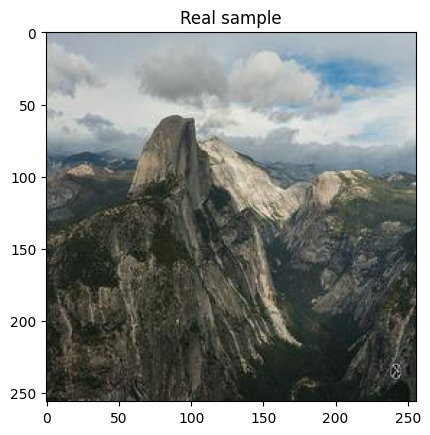

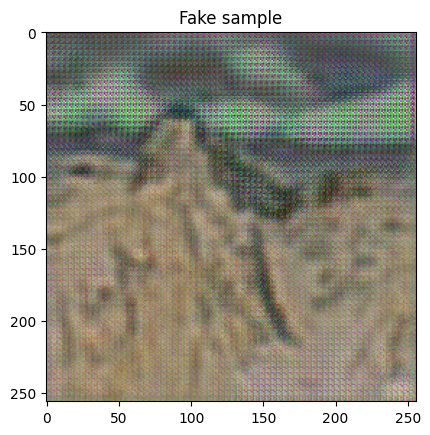

Epoch [  550/ 5000] | D_loss: 0.0033 | G_loss: 3.6411
Epoch [  600/ 5000] | D_loss: 0.0024 | G_loss: 3.2439
Epoch [  650/ 5000] | D_loss: 0.0024 | G_loss: 4.3859
Epoch [  700/ 5000] | D_loss: 0.0017 | G_loss: 3.5214
Epoch [  750/ 5000] | D_loss: 0.0019 | G_loss: 4.4474
Epoch [  800/ 5000] | D_loss: 0.0012 | G_loss: 3.1805
Epoch [  850/ 5000] | D_loss: 0.0013 | G_loss: 3.0257
Epoch [  900/ 5000] | D_loss: 0.0013 | G_loss: 3.3917
Epoch [  950/ 5000] | D_loss: 0.0011 | G_loss: 3.0482
Epoch [ 1000/ 5000] | D_loss: 0.0012 | G_loss: 3.4304


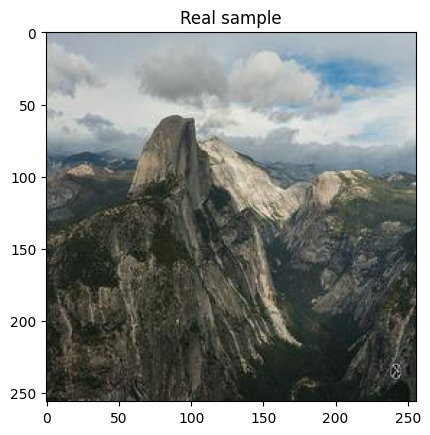

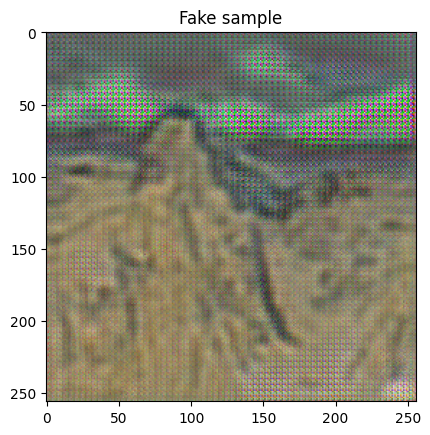

Epoch [ 1050/ 5000] | D_loss: 0.0008 | G_loss: 3.3349
Epoch [ 1100/ 5000] | D_loss: 0.0008 | G_loss: 3.4531
Epoch [ 1150/ 5000] | D_loss: 0.0008 | G_loss: 2.7508
Epoch [ 1200/ 5000] | D_loss: 0.0009 | G_loss: 3.4690
Epoch [ 1250/ 5000] | D_loss: 0.0008 | G_loss: 3.5396
Epoch [ 1300/ 5000] | D_loss: 0.0007 | G_loss: 2.8705
Epoch [ 1350/ 5000] | D_loss: 0.0005 | G_loss: 3.1247
Epoch [ 1400/ 5000] | D_loss: 0.0005 | G_loss: 3.2597
Epoch [ 1450/ 5000] | D_loss: 0.0005 | G_loss: 2.8126
Epoch [ 1500/ 5000] | D_loss: 0.0005 | G_loss: 2.9762


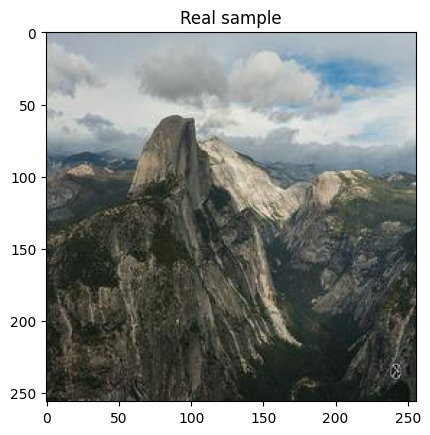

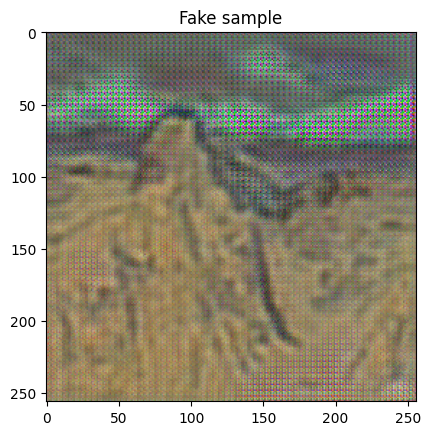

Epoch [ 1550/ 5000] | D_loss: 0.0003 | G_loss: 2.4593
Epoch [ 1600/ 5000] | D_loss: 0.0004 | G_loss: 3.3338
Epoch [ 1650/ 5000] | D_loss: 0.0003 | G_loss: 2.6093
Epoch [ 1700/ 5000] | D_loss: 0.0004 | G_loss: 2.7237
Epoch [ 1750/ 5000] | D_loss: 0.0003 | G_loss: 2.8401
Epoch [ 1800/ 5000] | D_loss: 0.0006 | G_loss: 3.3140
Epoch [ 1850/ 5000] | D_loss: 0.0003 | G_loss: 2.7304
Epoch [ 1900/ 5000] | D_loss: 0.0003 | G_loss: 3.0394
Epoch [ 1950/ 5000] | D_loss: 0.0003 | G_loss: 2.3333
Epoch [ 2000/ 5000] | D_loss: 0.0003 | G_loss: 2.3715


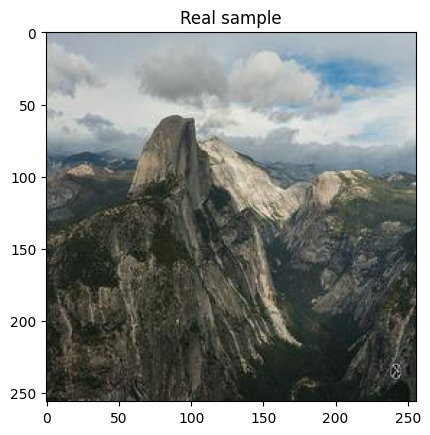

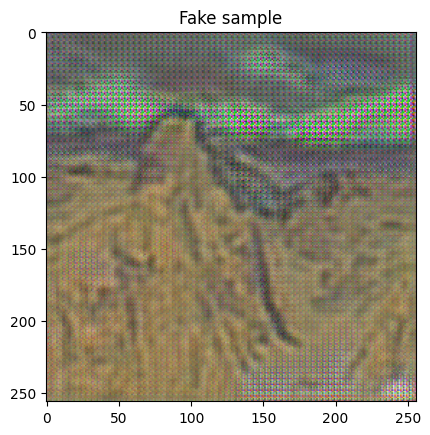

Epoch [ 2050/ 5000] | D_loss: 0.0003 | G_loss: 2.9304
Epoch [ 2100/ 5000] | D_loss: 0.0002 | G_loss: 3.0594
Epoch [ 2150/ 5000] | D_loss: 0.0002 | G_loss: 2.9507
Epoch [ 2200/ 5000] | D_loss: 0.0002 | G_loss: 2.6964
Epoch [ 2250/ 5000] | D_loss: 0.0003 | G_loss: 3.4468
Epoch [ 2300/ 5000] | D_loss: 0.0003 | G_loss: 2.7855
Epoch [ 2350/ 5000] | D_loss: 0.0002 | G_loss: 2.5482
Epoch [ 2400/ 5000] | D_loss: 0.0002 | G_loss: 2.7824
Epoch [ 2450/ 5000] | D_loss: 0.0002 | G_loss: 2.4208
Epoch [ 2500/ 5000] | D_loss: 0.0002 | G_loss: 2.3613


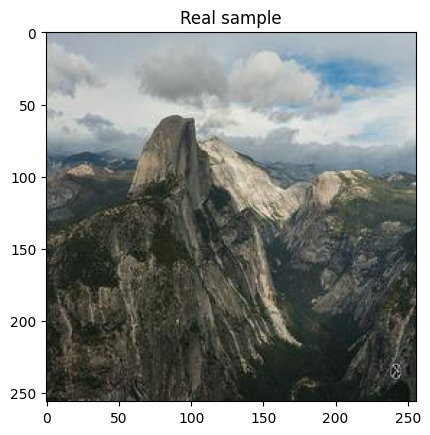

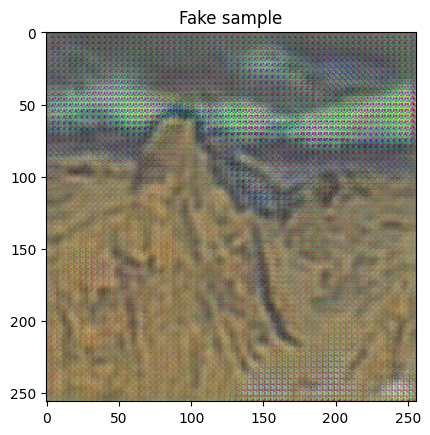

Epoch [ 2550/ 5000] | D_loss: 0.0001 | G_loss: 2.5220
Epoch [ 2600/ 5000] | D_loss: 0.0002 | G_loss: 2.5285
Epoch [ 2650/ 5000] | D_loss: 0.0001 | G_loss: 2.4246
Epoch [ 2700/ 5000] | D_loss: 0.0002 | G_loss: 3.0621
Epoch [ 2750/ 5000] | D_loss: 0.0001 | G_loss: 2.5530
Epoch [ 2800/ 5000] | D_loss: 0.0002 | G_loss: 2.9774
Epoch [ 2850/ 5000] | D_loss: 0.0001 | G_loss: 2.3678
Epoch [ 2900/ 5000] | D_loss: 0.0001 | G_loss: 2.5919
Epoch [ 2950/ 5000] | D_loss: 0.0001 | G_loss: 2.1899
Epoch [ 3000/ 5000] | D_loss: 0.0001 | G_loss: 2.3870


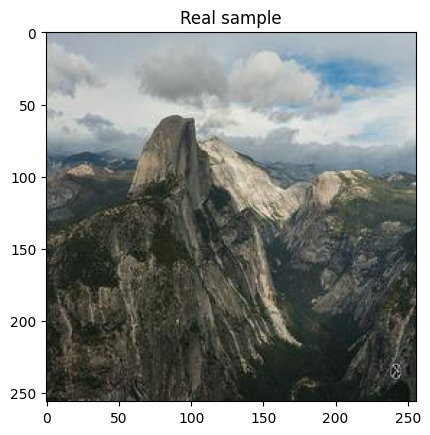

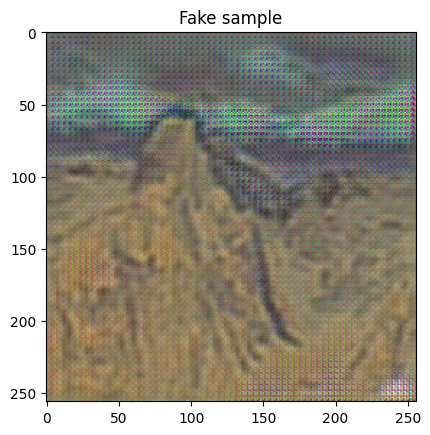

Epoch [ 3050/ 5000] | D_loss: 0.0001 | G_loss: 2.2583
Epoch [ 3100/ 5000] | D_loss: 0.0001 | G_loss: 2.5120
Epoch [ 3150/ 5000] | D_loss: 0.0001 | G_loss: 2.3902
Epoch [ 3200/ 5000] | D_loss: 0.0001 | G_loss: 2.3583
Epoch [ 3250/ 5000] | D_loss: 0.0001 | G_loss: 2.3826
Epoch [ 3300/ 5000] | D_loss: 0.0001 | G_loss: 2.8848
Epoch [ 3350/ 5000] | D_loss: 0.0001 | G_loss: 2.1858
Epoch [ 3400/ 5000] | D_loss: 0.0001 | G_loss: 2.1419
Epoch [ 3450/ 5000] | D_loss: 0.0001 | G_loss: 2.6045
Epoch [ 3500/ 5000] | D_loss: 0.0001 | G_loss: 2.6974


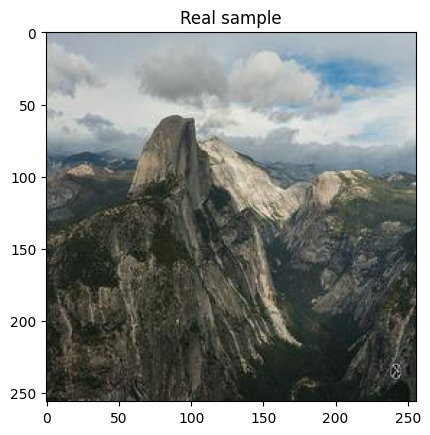

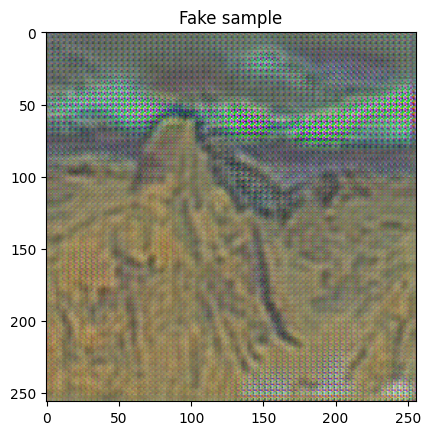

Epoch [ 3550/ 5000] | D_loss: 0.0001 | G_loss: 2.5599
Epoch [ 3600/ 5000] | D_loss: 0.0001 | G_loss: 2.4558
Epoch [ 3650/ 5000] | D_loss: 0.0001 | G_loss: 2.3527
Epoch [ 3700/ 5000] | D_loss: 0.0001 | G_loss: 2.4321
Epoch [ 3750/ 5000] | D_loss: 0.0001 | G_loss: 2.6978
Epoch [ 3800/ 5000] | D_loss: 0.0001 | G_loss: 2.1622
Epoch [ 3850/ 5000] | D_loss: 0.0001 | G_loss: 2.4005
Epoch [ 3900/ 5000] | D_loss: 0.0001 | G_loss: 2.9041
Epoch [ 3950/ 5000] | D_loss: 0.0001 | G_loss: 2.3188
Epoch [ 4000/ 5000] | D_loss: 0.0000 | G_loss: 2.4804


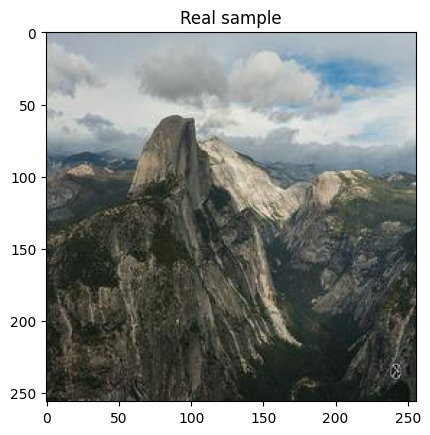

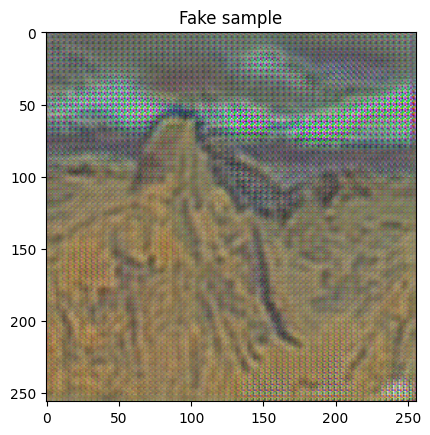

Epoch [ 4050/ 5000] | D_loss: 0.0000 | G_loss: 2.1568
Epoch [ 4100/ 5000] | D_loss: 0.0001 | G_loss: 2.6467
Epoch [ 4150/ 5000] | D_loss: 0.0000 | G_loss: 2.4481
Epoch [ 4200/ 5000] | D_loss: 0.0001 | G_loss: 2.1401
Epoch [ 4250/ 5000] | D_loss: 0.0001 | G_loss: 2.6320
Epoch [ 4300/ 5000] | D_loss: 0.0001 | G_loss: 2.1985
Epoch [ 4350/ 5000] | D_loss: 0.0000 | G_loss: 2.3252
Epoch [ 4400/ 5000] | D_loss: 0.0001 | G_loss: 2.1427
Epoch [ 4450/ 5000] | D_loss: 0.0001 | G_loss: 2.8190
Epoch [ 4500/ 5000] | D_loss: 0.0000 | G_loss: 2.0791


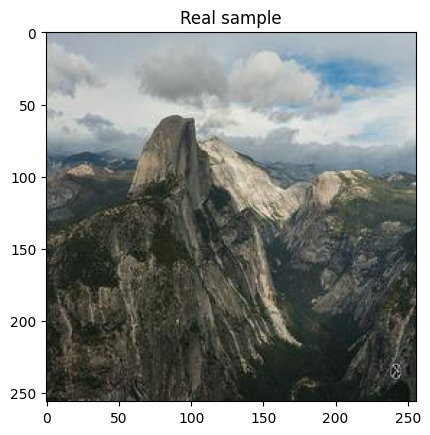

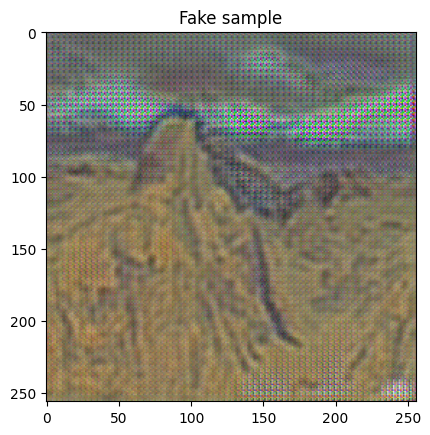

Epoch [ 4550/ 5000] | D_loss: 0.0000 | G_loss: 2.7395
Epoch [ 4600/ 5000] | D_loss: 0.0001 | G_loss: 2.8533
Epoch [ 4650/ 5000] | D_loss: 0.0000 | G_loss: 1.9768
Epoch [ 4700/ 5000] | D_loss: 0.0000 | G_loss: 1.9972
Epoch [ 4750/ 5000] | D_loss: 0.0000 | G_loss: 2.8499
Epoch [ 4800/ 5000] | D_loss: 0.0000 | G_loss: 1.9779
Epoch [ 4850/ 5000] | D_loss: 0.0000 | G_loss: 2.4524
Epoch [ 4900/ 5000] | D_loss: 0.0000 | G_loss: 2.2033
Epoch [ 4950/ 5000] | D_loss: 0.0000 | G_loss: 2.5735
Epoch [ 5000/ 5000] | D_loss: 0.0000 | G_loss: 2.2932


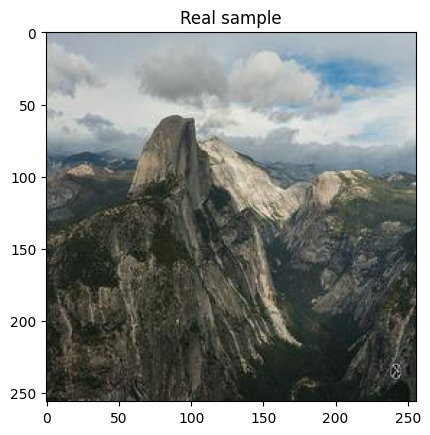

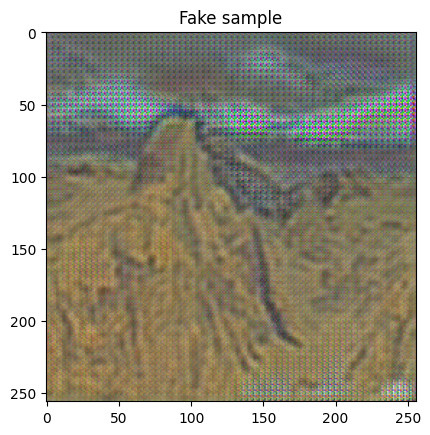

In [20]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

D_X = Discriminator().to(device)
D_Y = Discriminator().to(device)
G_X2Y = Generator(img_channels=3).to(device)
G_Y2X = Generator(img_channels=3).to(device)

opt_D = torch.optim.Adam(
    list(D_X.parameters()) + list(D_Y.parameters()),
    lr=1e-5,
    betas=(0.5, 0.999)   
)

opt_G = torch.optim.Adam(
    list(G_X2Y.parameters()) + list(G_Y2X.parameters()),
    lr=1e-5,
    betas=(0.5, 0.999)   
)

L1 = nn.L1Loss()
mse = nn.MSELoss()

G_scaler = torch.cuda.amp.GradScaler()
D_scaler = torch.cuda.amp.GradScaler()

train(G_X2Y, G_Y2X, D_X, D_Y, X_dataloader, Y_dataloader, opt_G, opt_D, L1, mse, G_scaler, D_scaler)

In [21]:
X_set = GANdataGenerator(data_dir='../input/gan-getting-started/photo_jpg' , data_files=photo_jpg , image_size=256 )

X_dataloader = DataLoader(X_set, batch_size=1, shuffle=True, num_workers=0)

! mkdir ../images

i = 1
for fix_x  in X_dataloader:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    fake_Y = G_X2Y(fix_x.to(device))
    
    prediction = to_data(fake_Y)
    im = PIL.Image.fromarray(prediction)
    
    im.save("../images/" + str(i) + ".jpg")
    i += 1
    
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")



'/kaggle/working/images.zip'